In [1]:
import sys
import os
import numpy as np
import numpy.linalg as la 
import torch
from tqdm import tqdm

from ControlRF import GPController, ADPKernel, ADPRandomFeatures, ADKernel, ADRandomFeatures, VanillaKernel, VanillaRandomFeatures
from ControlRF.plots import *
from ControlRF.util import *

from core.controllers import QPController, LQRController, FBLinController
from core.dynamics import AffineQuadCLF
from core.systems import InvertedPendulum, DoubleInvertedPendulum

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
system_est = DoubleInvertedPendulum(5,4,0.2,0.5)
Q , R = 10*np.identity(4), np.identity(2)
lyap_est = AffineQuadCLF.build_care(system_est, Q, R) 
alpha = min(la.eigvalsh(Q)) / max(la.eigvalsh(lyap_est.P))

model_lqr = LQRController.build(system_est, Q, R)
model_fb_lin = FBLinController(system_est, model_lqr)
# fb_lin_data = system.simulate(x_0, fb_lin, ts) #1

qp_controller = QPController.build_care(system_est, Q, R)
qp_controller.add_regularizer(model_fb_lin, 25)
qp_controller.add_static_cost(np.identity(2))
qp_controller.add_stability_constraint(lyap_est, comp=lambda r: alpha * r, slacked=True, coeff = 1e5)
#plot_simulation_dip(system, controller, 'qp_controller', x_0, T=100, num_steps=1000)s

In [3]:
l_1 = 1
l_2 = 1
system = DoubleInvertedPendulum(0.2,0.2,l_1,l_2) 
lyap = AffineQuadCLF.build_care(system, Q, R) 
alpha = min(la.eigvalsh(Q)) / max(la.eigvalsh(lyap.P))

lqr = LQRController.build(system, Q, R)
fb_lin = FBLinController(system, lqr)
oracle_controller = QPController.build_care(system, Q, R)
oracle_controller.add_regularizer(fb_lin, 25)
oracle_controller.add_static_cost(np.identity(2))
oracle_controller.add_stability_constraint(lyap, comp=lambda r: alpha * r, slacked=True, coeff = 1e5)


In [14]:
create_data(system, qp_controller, lyap_est, T, num_steps)
print(xs.shape)

NameError: name 'create_data' is not defined

In [ ]:
def dip_train(system_est, lyap_est, xs, ys, zs):
    ad_rf = ADRandomFeatures(xs, ys, zs, rf_d=1500)
    adp_rf = ADPRandomFeatures(xs, ys, zs, rf_d=1500)
    ad_kernel = ADKernel(xs, ys, zs)
    adp_kernel = ADPKernel(xs, ys, zs)
    gps = [ad_kernel, ad_rf, adp_kernel, adp_rf]
    controllers = []
    for gp in gps:
        print(gp.__name__)
        gp_controller = GPController(system_est, gp)
        gp_controller.add_regularizer(fb_lin, 25)
        gp_controller.add_static_cost(np.identity(2))
        gp_controller.add_stability_constraint(lyap_est, comp=alpha, slacked=True, beta = 1, coeff=1e5)
        controllers.append(gp_controller)
        print(f'training time for {gp.__name__}_gp is: {gp.training_time}')
    return controllers, gps

In [ ]:
controllers, gps = dip_train(system_est, lyap_est, xs, ys, zs)

ad_kernel
training time for ad_kernel_gp is: 8.225605305
ad_rf
training time for ad_rf_gp is: 1.0317084429999994
adp_kernel
training time for adp_kernel_gp is: 5.594553171000001
adp_rf
training time for adp_rf_gp is: 4.920624944


In [ ]:
def plot_c_dot(system, lyap, lyap_est, controllers, gps, qp_controller, oracle_controller, x_0, T=10, num_steps=200):
	'''plotting true C_dot using specified controller over time'''
	c = 1
	ts = np.linspace(0, T, num_steps)[1:]
	fmts = ['c-','m-','y-','r-']
	zs_fmts = ['b.','g.','r.', 'k.']


	ax = plt.figure(figsize=(8, 6), tight_layout=True).add_subplot(1, 1, 1)
	ax.set_xlabel('$t$', fontsize=16)

	for controller,gp,fmt in zip(controllers,gps,fmts):
		zs = c_dot(system, controller, lyap_est, x_0, T, num_steps)
		ax.plot(ts, zs, fmt, label=gp.__name__+' controller', markersize=c, alpha=.4)


	qp_zs = c_dot(system, qp_controller, lyap_est, x_0, T, num_steps)
	ax.plot(ts, qp_zs, '-',label='qp_controller', markersize=c)
	
	
	model_zs = c_dot(system, oracle_controller, lyap, x_0, T, num_steps)
	
	ax.plot(ts, model_zs, 'k-.',label='oracle_controller', markersize=c)
	
	ax.legend()
	plt.show()
	plt.close()

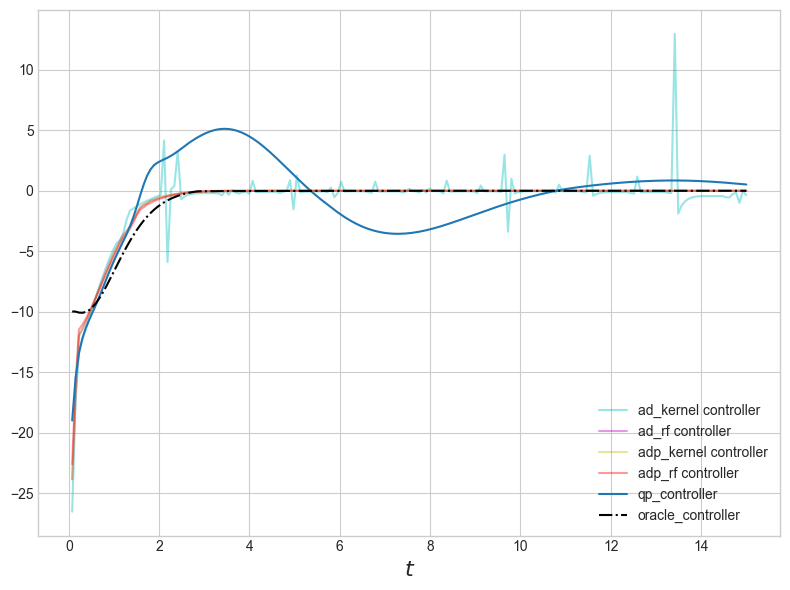

In [ ]:
x_0 = np.array([1,0,0,0])
plot_c_dot(system, lyap, lyap_est, controllers, gps, qp_controller, oracle_controller, x_0, T=10, num_steps=200)